# You Too Can Become a Wine Expert
### Data Mining, Spring 2019<br /> Zeynep Akca, Nathan Ayala, Luke Burns

#####  Attribution:

Zeynep: Adaboost, presentation, report, moral support for Luke's cool table

Nathan: Neural Network (Multiclass), presentation, report, no moral support for Luke's table

Luke: Neural Network (AUC), presentation, report, I made the cool table

## Introduction to the Data

The data was collected from May 2004 to February 2007 using samples that were tested at the official certification entity, the Comissão de Viticultura da Região dos Vinhos (CVRVV). The data is only on wine from the northwest of Portugal and the wine is known as vinho verde and this wine accounts for 15 % of Portuguese production. The data was recorded by a computer system that automatically managed the wine sample testing. The dataset contains information on 1599 red wines and 4898 white wines. The input variables are objective physiochemical measures of the wine and the output variable is the objective score of the wine. Each wine was graded in a blind taste test between 0 (very bad) and 10 (very excellent) by at least three experts and the median of these scores is the output variable. The dataset itself is very uneven, with many more average wines than very good or very bad, with no wines receiving a score of 0, 1, 2 or 10, and only 5 wines receiving a score of 9. The input variables are the most common physicochemical as to maximize the size of the dataset, which avoided discarding wine examples. These variables are fixed acidity, volatile acidity, citric acid, residual sugar chlorides, free sulfur dioxide, total sulfur dioxide, density pH, sulphates, and alcohol.

## Defining the Problem

The aim of this project is to classify wine data in terms of its quality. The quality ranges between 0 and 10. Scores are the medians of three experts’ ratings. For each wine there are 11 features. These features are: 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'. Because we have two different data sets (one for red wine and another for white), we combined these two and added a new feature called 'type'.

For various analysis techniques, we've made certain assumptions in order to apply these techniques. For instance, in our Naive Bayes analysis (which we did not end up selecting as our chosen model), we assumed conditional independence of the features. However, for the most part, our chosen analysis (AdaBoost) required few assumptions about the data.

An analysis of the kind we carried out here could be helpful for wine producers in identifying the main contributing factors to good wine. It might also be helpful for learning what features experts are detecting in order to classify wine, so that you too might become a wine expert!

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import matplotlib as mp

from sklearn.datasets import make_classification, make_moons
from sklearn import preprocessing as preproc
from sklearn import metrics
from sklearn import model_selection as ms
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from sklearn.decomposition import PCA

In [3]:
# import data
white_df = pd.read_csv('winequality-white.csv', sep =';')
red_df = pd.read_csv('winequality-red.csv', sep =';')


## Understanding Our Data

All of our data are clean — no errors or NaNs, and no categorical data. As we see in the graphs below, the quality scores are not balanced. There are strong correlations between features, such as residual sugar and density; pH and fixed acidity; and alcohol and density. The scatter plots shown indicate coarse linear relationships between some features and quality. We see that these relationships differ for white and red wine, so we consider them separately.

### White Wine

In [11]:
wX = white_df.drop(['quality'], axis=1)
wy = white_df ['quality']
print(wX.shape)
white_df.head()

(4898, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


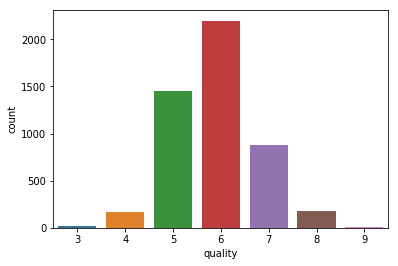

In [12]:
sns.countplot(wy,label="Count")
plt.show()

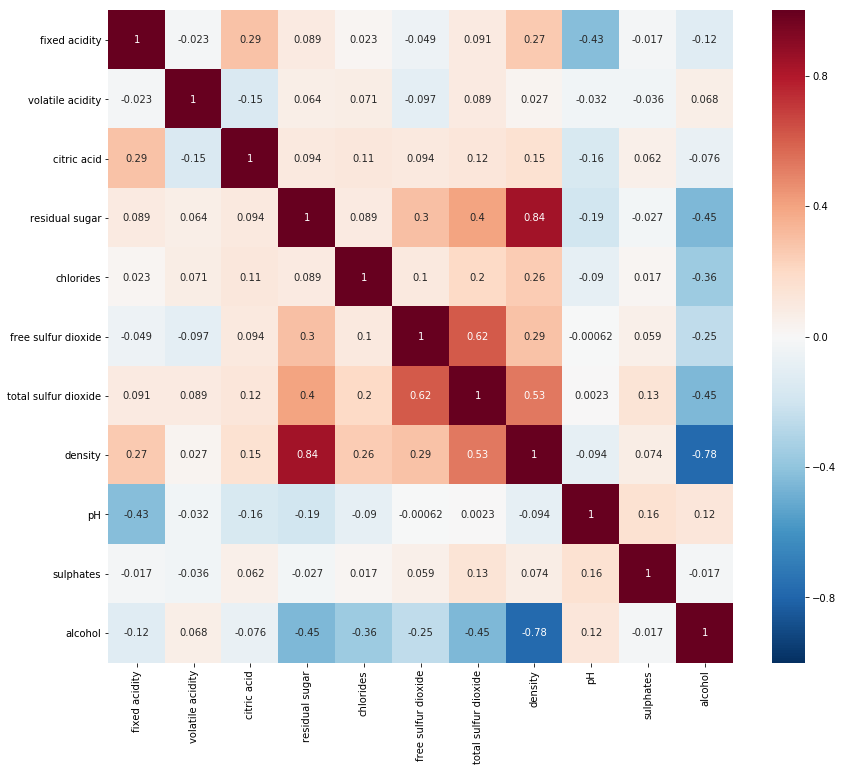

In [35]:
correlation = wX.corr(method='pearson')
plt.figure(figsize=(14,12))
heatmap = sns.heatmap(correlation, annot = True, linewidths = 0, vmin=-1, cmap = "RdBu_r")

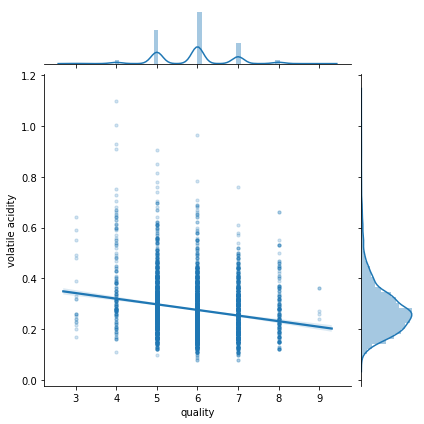

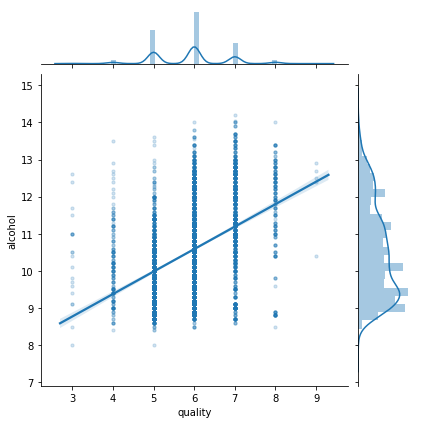

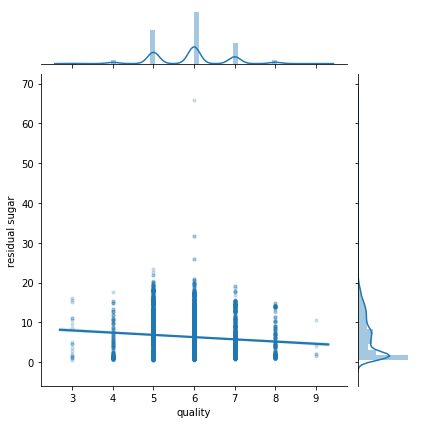

In [43]:
# joint regression-marginal plots

# volatile acidity
volatileAcidity_quality = white_df[['quality', 'volatile acidity']]
gridA = sns.JointGrid(x="quality", y="volatile acidity", data=volatileAcidity_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

# alcohol
alcohol_quality = white_df[['quality', 'alcohol']]
gridA = sns.JointGrid(x="quality", y="alcohol", data=alcohol_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

# residual sugar
alcohol_quality = white_df[['quality', 'residual sugar']]
gridA = sns.JointGrid(x="quality", y="residual sugar", data=alcohol_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

### Red Wine

In [39]:
rX = red_df.drop(['quality'], axis=1)
ry = red_df['quality']
print(rX.shape)
red_df.head()

(1599, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


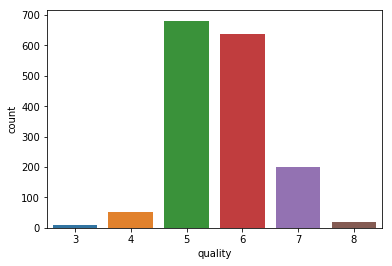

In [40]:
sns.countplot(ry,label="Count")
plt.show()

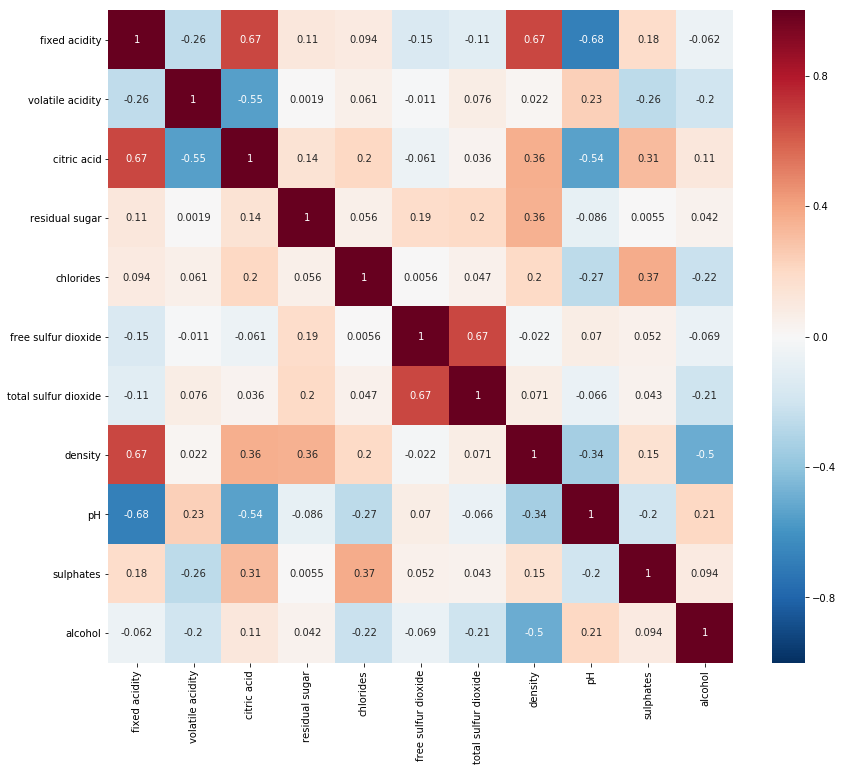

In [41]:
correlation = rX.corr(method='pearson')
plt.figure(figsize=(14,12))
heatmap = sns.heatmap(correlation, annot = True, linewidths = 0, vmin=-1, cmap = "RdBu_r")

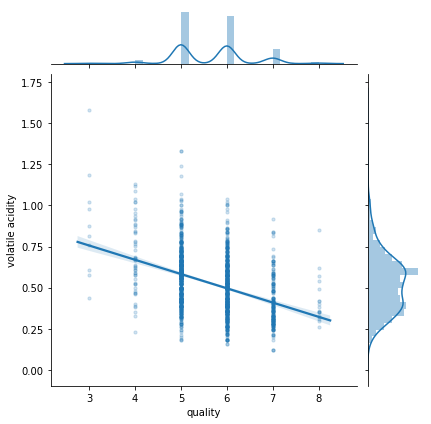

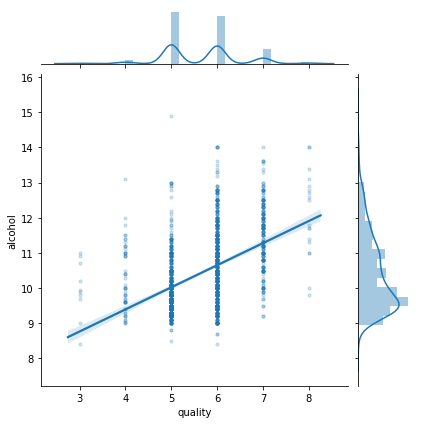

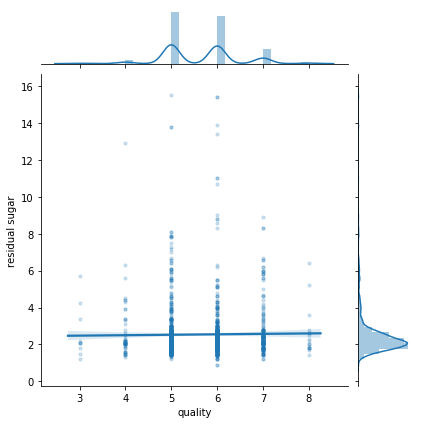

In [44]:
# joint regression-marginal plots

# volatile acidity
volatileAcidity_quality = red_df[['quality', 'volatile acidity']]
gridA = sns.JointGrid(x="quality", y="volatile acidity", data=volatileAcidity_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

# alcohol
alcohol_quality = red_df[['quality', 'alcohol']]
gridA = sns.JointGrid(x="quality", y="alcohol", data=alcohol_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

# residual sugar
alcohol_quality = red_df[['quality', 'residual sugar']]
gridA = sns.JointGrid(x="quality", y="residual sugar", data=alcohol_quality, height=6)
gridA = gridA.plot_joint(sns.regplot, scatter_kws={"s": 10, 'alpha': 0.2})
gridA = gridA.plot_marginals(sns.distplot)

## Model building

In preprocessing, we standardized and upsampled our training data to account for quality imbalance, although we considered models without upsampling as well for comparison. For various models, we consider subsets of the features identified via correlation or PCA analysis. We also engineered quality classes for different models — we considered reduced multiclass and binary classification, splitting up quality scores in various ways.

Our focus was on binary classification models, in which we decided to split quality scores into two classes $\text{quality} < 7$ and $\text{quality} >= 7$. This decision was based on a combination of usefulness of the predictions (e.g. distinguishing between wines below 3 and greater than 3 isn't particularly helpful) and limitations of the data, which are mostly of quality 5, 6, and 7. For white wine, 78% of samples score $\leq 7$ (are class 0), and for red wine, 86% of samples scores $\leq 7$ (are class 0). This gives us a baseline test for the accuracy of our models.

While our focus was binary, we've included a multiclass model in the appendix, in which we split into 5 classes $\text{quality} \leq 4$, $\text{quality} = 5$, $\text{quality} = 6$, $\text{quality} = 7$, and $\text{quality} \geq 8$.

We considered a number of models, analyses included in this notebook below. A summary is presented in the following table with accuracy and AUC metrics for each. While accuracy is important, the imbalance in our data allows a model that always predicts the majority class to achieve high accuracy. AUC is robust against this imbalance and allows us to select models with high True Positive and low False Positive rates. A model with a high AUC is like a strong critic, who may predict that a good wine is bad (false negative), but is less likely to predict that a bad wine is good (a false positive). It's like a movie critic, who might say a good movie is bad and still be a good critic, but will rarely say a bad movie is good, which would make them a bad critic.

Which model you select depends on the questions your are asking. For instance, if you simply want to classify as many wines correctly as possible, guessing all wines are bad is going to get you 86% of the way there. On the other hand, if you are interested in being the best critic, then our neural network, which minimizes a loss function that maximizes AUC [1], is the best model for this purpose. However, while our neural net has a higher AUC than AdaBoost, its accuracy is significantly lower. For this reason, we consider AdaBoost to be a stronger model, as it has both high AUC and accuracy. It is worth noting that a model that performs worse than chance on accuracy can still be a useful model if it has a high AUC.

Improvements that can be made might include a more intensive grid search to optimize hyperparameters or feature engineering given more domain knowledge about wine. We might also consider downsampling instead of upsampling or other boosting algorithms, like CatBoost.

A detailed analysis of each model is available in this notebook below.

<table style="font-size: 16px">
<thead>
<tr>
  <th style="text-align: center; font-weight: normal; color: red;">*</th>
  <th style="text-align: center" colspan="2">White Wine</th>
  <th style="text-align: center" colspan="2">Red Wine</th>
</tr>
</thead>
<tbody><tr>
  <td style="text-align: center"></td>
  <td style="text-align: center">AUC Score</td>
  <td style="text-align: center">Accuracy Score</td>
  <td style="text-align: center">AUC Score</td>
  <td style="text-align: center">Accuracy Score</td>
</tr>
<tr>
  <td style="text-align: right">KNN</td>
  <td style="text-align: center">0.68</td>
  <td style="text-align: center">0.82</td>
  <td style="text-align: center">0.71</td>
  <td style="text-align: center">0.89</td>
</tr>
<tr>
  <td style="text-align: right">Random Forest</td>
  <td style="text-align: center">0.82</td>
  <td style="text-align: center">0.85</td>
  <td style="text-align: center">0.76</td>
  <td style="text-align: center">0.93</td>
</tr>
<tr>
  <td style="text-align: right">Naive Bayes</td>
  <td style="text-align: center">0.71</td>
  <td style="text-align: center">0.72</td>
  <td style="text-align: center">0.88</td>
  <td style="text-align: center">0.8</td>
</tr>
<tr>
  <td style="text-align: right">Neural Net</td>
  <td style="text-align: center">0.84</td>
  <td style="text-align: center">0.73</td>
  <td style="text-align: center">0.85</td>
  <td style="text-align: center">0.77</td>
</tr>
<tr style="font-weight: 800;">
  <td style="text-align: right">Adaboost</td>
  <td style="text-align: center">0.81</td>
  <td style="text-align: center">0.9</td>
  <td style="text-align: center">0.84</td>
  <td style="text-align: center">0.9</td>
</tr>
</tbody></table>

<span style="text-align: center; font-weight: normal; color: red;">*</span> Luke made this cool table

[1] Yan, L., Dodier, R., Mozer, M. C., & Wolniewicz, R. (2003). Optimizing Classifier Performance via an Approximation to the Wilcoxon-Mann-Whitney Statistic.

## Future Work

A good next step would be to explore models with a more sophisticated palette that can discern between more than just two coarse classifications of wine quality. For instance, we could consider something similar to the original investigation of this dataset[2] which allowed for some tolerance in predictions, such that a quality prediction on a scale from 1-10 was considered correct if it was off by at most 1.

That said, the imbalance in our data is our greatest bottleneck, imposing fundamental limitations on our models. Collecting more data, possibly from other sources, would allow us to improve upon our existing work. If we had access to raw expert ratings, rather than just the median score of some unknown number of experts, we might be able to use that information to better understand the factors that influence expert opinions. Additional features that can't be engineered might also help, such as aging time, grape quality, year of grape harvest, climate during harvest, etc.

[2] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision Support Systems, 47(4), 547-553.

# Binary Classification

## Overview

We take $0 \sim y < 7$ and $1 \sim y >= 7$. The decision two split the data this way was based on a combination of usefulness of the predictions (e.g. distinguishing between wines below 3 and greater than 3 isn't particularly helpful) and limitations of the data, which are mostly of quality 5, 6, and 7. See the dataframes and histograms below.

Below we consider white wine and red wine quality classification using AdaBoost. Other models can be found in the appendix. We analyze our AdaBoost models with and without upsampling, and find that upsampling doesn't always improve performance. In some cases the models without upsampling outperform.

We found that the maximum tree depth has a significant effect on model performance, so we've plotted accuracy and AUC against the max_depth to select the best model. This hyperparameter determines the highest tree depth that AdaBoost would consider. Because AdaBoost samples randomly at each branching step, we ran the same model multiple times in order to determine how consistent its accuracy and AUC scores are.

Our scores for our best performing models are given below.

<h2 style="text-align: center">All Features</h2>

<img src="ada-all.png">

<h2 style="text-align: center">Volatile Acidity, Alcohol, Residual Sugar</h2>

<img src="ada-corr.png">

<img src="ada-pca.png">

## Analysis

In [194]:
# upsampling helper function
def upsample(X_train, y_train):
    train_df = pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index])

    #upsampling scores 7-10 
    df_minority = train_df[train_df.quality==1]
    df_majority = train_df[train_df.quality==0]

    #amount to upsample
    samples =len(df_majority)

    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=samples,    # to match majority class
                                     random_state=123) # reproducible results

    #combining upsampled high and low
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])#, axis=1, join_axes=[df_majority.index])

    df_upsampled.quality.value_counts()

    #setting new y_train
    y_train = df_upsampled['quality']

    #setting new X_train
    df_upsampled = df_upsampled.drop(['quality'], axis=1)
    X_train = df_upsampled

    print('total samples',len(df_upsampled))
    input_dimension = df_upsampled.shape[1]
    
    return (X_train, y_train)

## Adaboost Analysis With All Features

### White Wine

#### Without upsampling

In [436]:
# split into training and validation data
wX_train, wX_test, wy_train, wy_test = ms.train_test_split(wX, wy, test_size=0.2)

wy_train[wy_train < 7] = 0
wy_train[wy_train > 6] = 1

wy_test[wy_test < 7] = 0
wy_test[wy_test > 6] = 1

print(wy_train.value_counts())
print(wy_test.value_counts())

# wX_train, wy_train = upsample(wX_train, wy_train)

scaler = preproc.StandardScaler()
scaler.fit(wX_train)
wX_train_sc = scaler.transform(wX_train)  # scale wX_train
wX_test_sc = scaler.transform(wX_test)  

0    3054
1     864
Name: quality, dtype: int64
0    784
1    196
Name: quality, dtype: int64


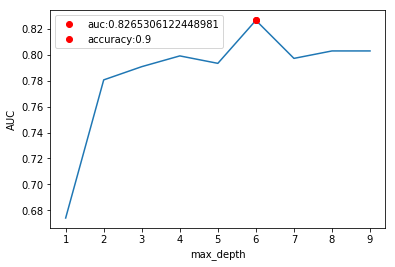

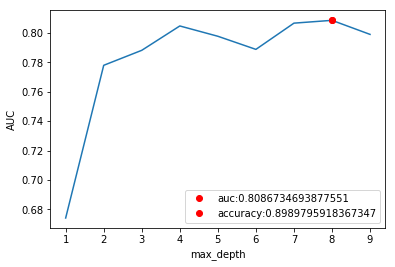

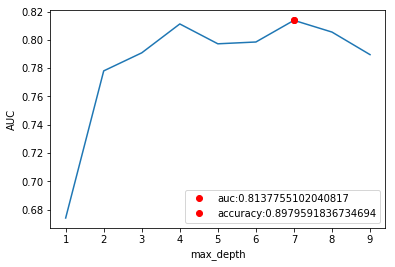

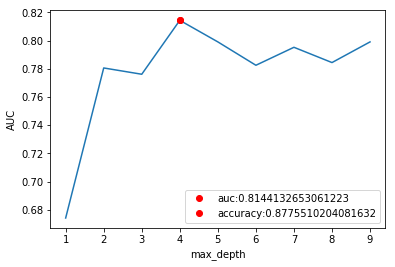

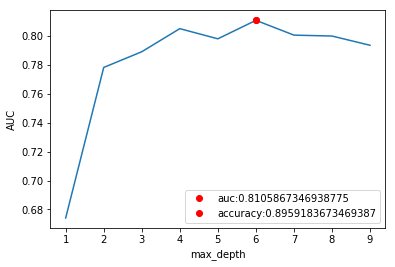

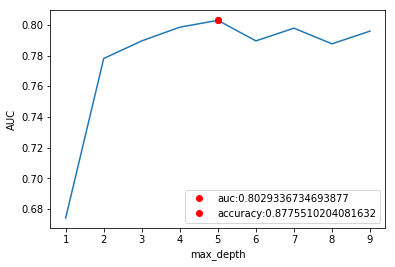

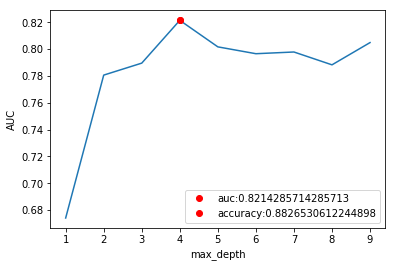

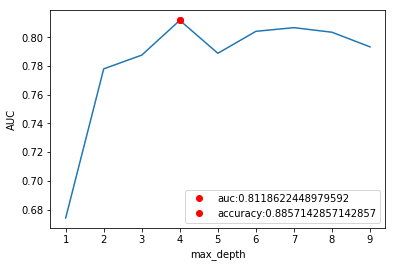

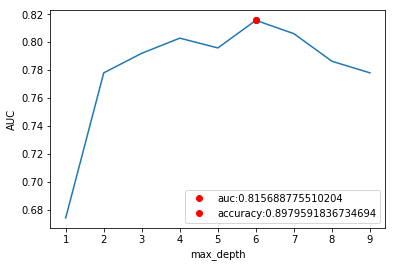

In [437]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(wX_train_sc, wy_train)
        a.append(i)
        b.append(metrics.roc_auc_score(wy_test, bdt.predict(wX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(wX_test_sc, wy_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### With upsampling

In [444]:
wX_train, wy_train = upsample(wX_train, wy_train) # upsample
scaler = preproc.StandardScaler()
scaler.fit(wX_train)
wX_train_sc = scaler.transform(wX_train)  # scale wX_train
wX_test_sc = scaler.transform(wX_test)  

total samples 6108


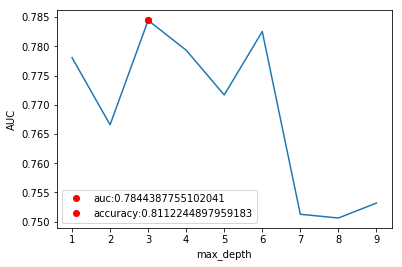

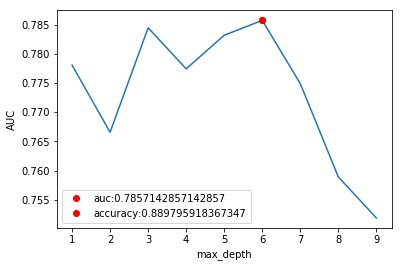

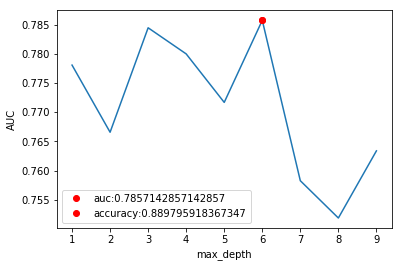

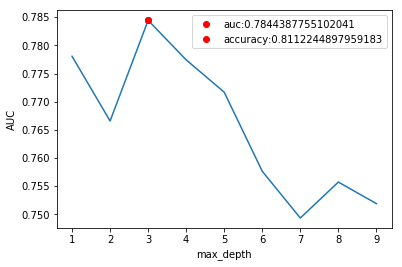

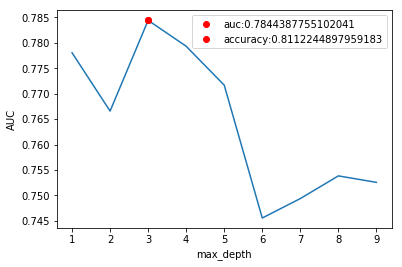

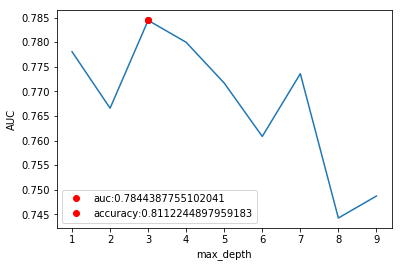

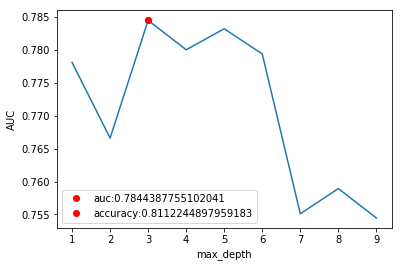

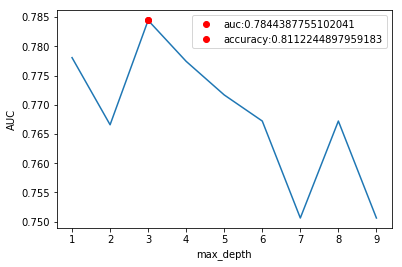

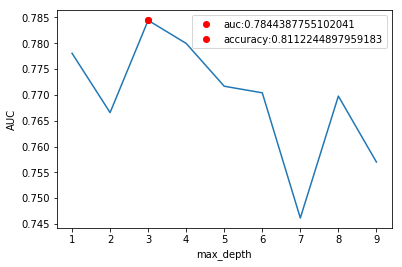

In [445]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(wX_train_sc, wy_train)
        a.append(i)
        b.append(metrics.roc_auc_score(wy_test, bdt.predict(wX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(wX_test_sc, wy_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

### Red Wine

#### Without upsampling

In [457]:
# split into training and validation sets
rX_train, rX_test, ry_train, ry_test = ms.train_test_split(rX, ry, test_size=0.2)

ry_train[ry_train < 7] = 0
ry_train[ry_train > 6] = 1

ry_test[ry_test < 7] = 0
ry_test[ry_test > 6] = 1

print(ry_train.value_counts())
print(ry_test.value_counts())

# rX_train, ry_train = upsample(rX_train, ry_train)

scaler = preproc.StandardScaler()
scaler.fit(rX_train)
rX_train_sc = scaler.transform(rX_train)  # scale rX_train
rX_test_sc = scaler.transform(rX_test)  

0    1107
1     172
Name: quality, dtype: int64
0    275
1     45
Name: quality, dtype: int64


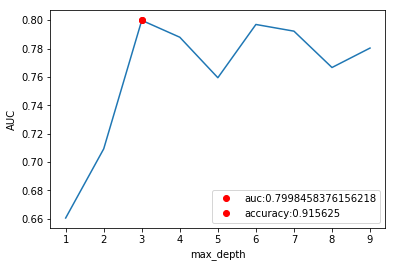

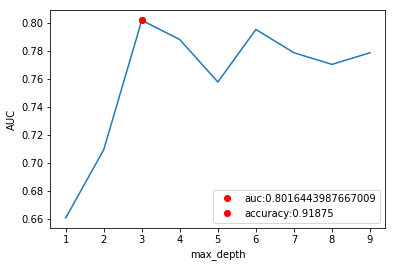

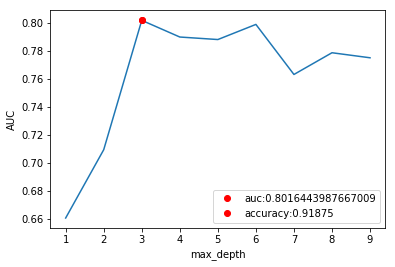

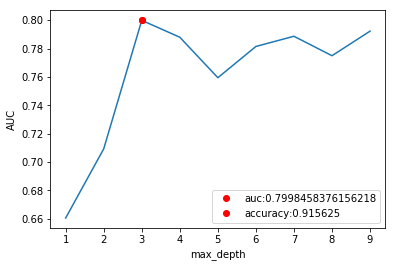

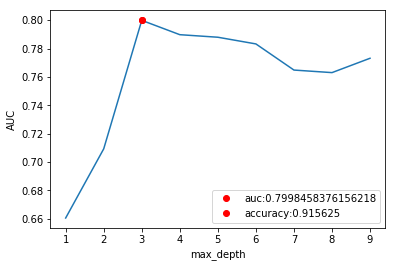

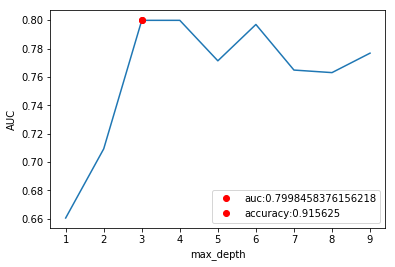

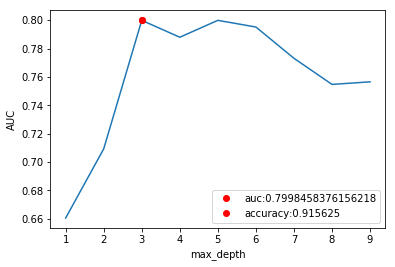

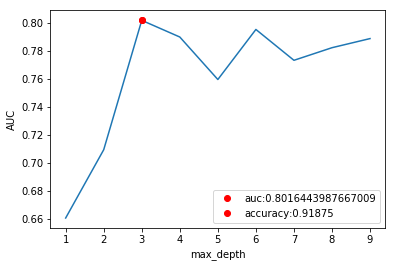

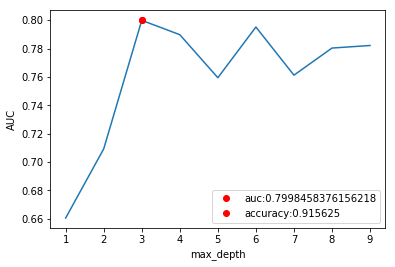

In [447]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):

        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(rX_train_sc, ry_train)
        a.append(i)
        b.append(metrics.roc_auc_score(ry_test, bdt.predict(rX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(rX_test_sc, ry_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### With upsampling

In [458]:
rX_train, ry_train = upsample(rX_train, ry_train) # upsample

scaler = preproc.StandardScaler()
scaler.fit(rX_train)
rX_train_sc = scaler.transform(rX_train)  # scale rX_train
rX_test_sc = scaler.transform(rX_test)  

train = pd.DataFrame(rX_train_sc)
train['quality'] = ry_train.to_numpy()

test = pd.DataFrame(rX_test_sc)
test['quality'] = ry_test.to_numpy()

train.to_csv('rtrain.csv')
test.to_csv('rtest.csv')

total samples 2214


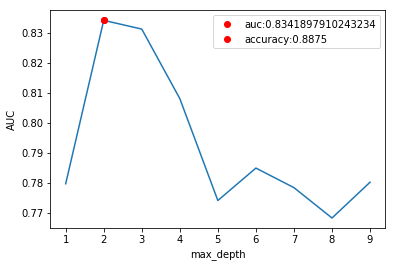

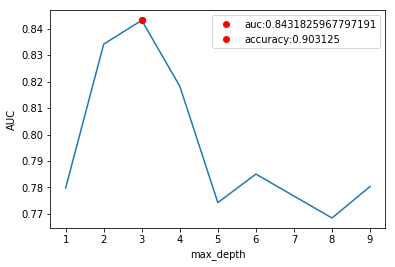

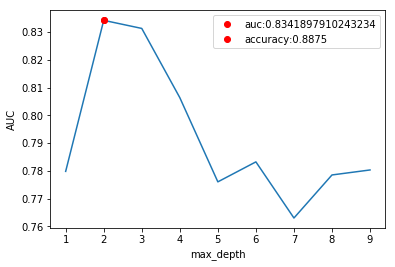

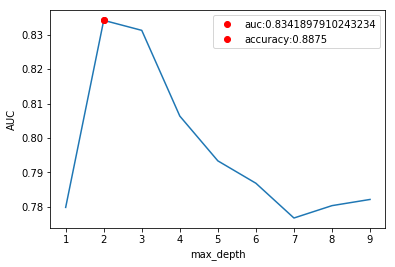

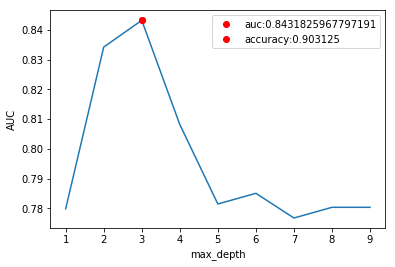

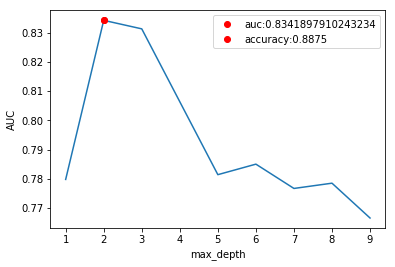

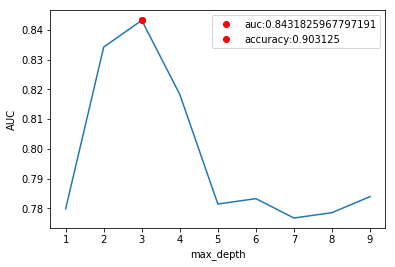

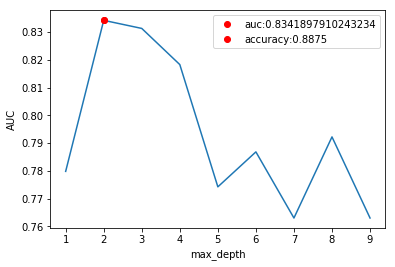

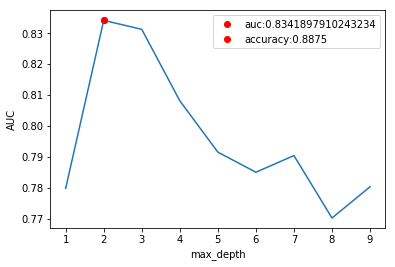

In [449]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)
        bdt.fit(rX_train_sc, ry_train)
        a.append(i)
        b.append(metrics.roc_auc_score(ry_test, bdt.predict(rX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(rX_test_sc, ry_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

# Subsets of Features

Based on correlations observed in the heatmap presented above, we considered the following models using a reduced number of features.

## AdaBoost with volatile acidity, alcohol, and residual sugar

### White Wine

#### Without upsampling

In [368]:
# select subset of features
wX_chosen = white_df[['volatile acidity', 'alcohol', 'residual sugar']]
X_train, X_test, y_train, y_test = ms.train_test_split(wX_chosen, wy, test_size=0.2)

In [369]:
y_train[y_train < 7] = 0
y_train[y_train > 6] = 1

y_test[y_test < 7] = 0
y_test[y_test > 6] = 1

print(y_train.value_counts())
print(y_test.value_counts())

0    3081
1     837
Name: quality, dtype: int64
0    757
1    223
Name: quality, dtype: int64


In [371]:
scaler = preproc.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)  # scale X_train
X_test_sc = scaler.transform(X_test)  

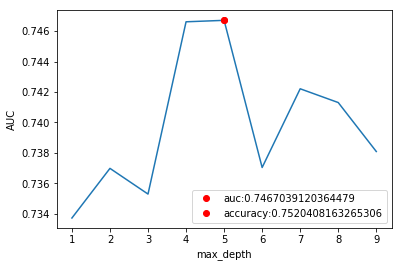

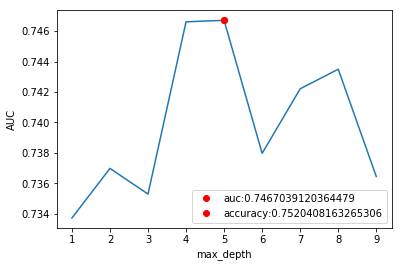

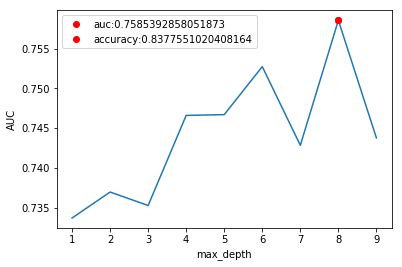

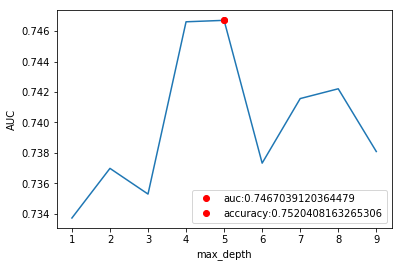

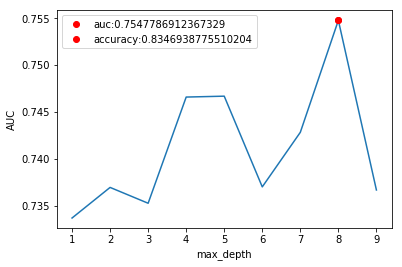

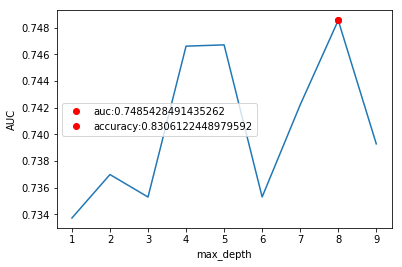

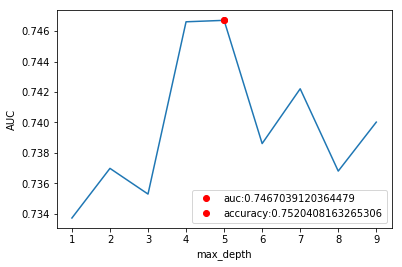

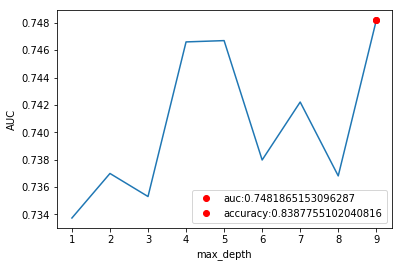

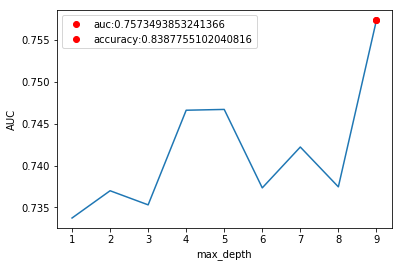

In [381]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []

    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)
        bdt.fit(X_train_sc, y_train)
        a.append(i)
        b.append(metrics.roc_auc_score(y_test, bdt.predict(X_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(X_test_sc, y_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max(b)))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(X_test_sc, y_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### With upsampling

In [382]:
wX_chosen = white_df[['volatile acidity', 'alcohol', 'residual sugar']]
X_train, X_test, y_train, y_test = ms.train_test_split(wX_chosen, wy, test_size=0.2)

In [383]:
y_train[y_train < 7] = 0
y_train[y_train > 6] = 1

y_test[y_test < 7] = 0
y_test[y_test > 6] = 1

print(y_train.value_counts())
print(y_test.value_counts())

0    3087
1     831
Name: quality, dtype: int64
0    751
1    229
Name: quality, dtype: int64


In [384]:
# upsample
X_train, y_train = upsample(X_train, y_train)

total samples 6174


In [385]:
scaler = preproc.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)  # scale X_train
X_test_sc = scaler.transform(X_test)  

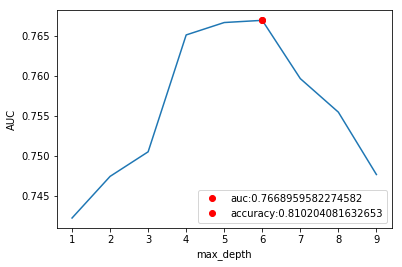

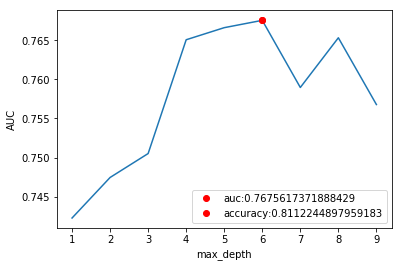

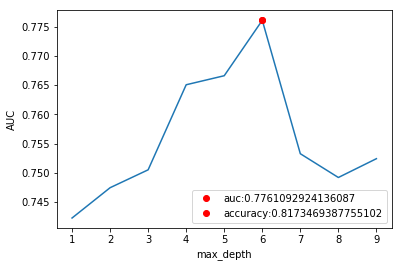

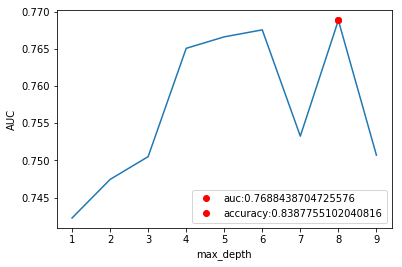

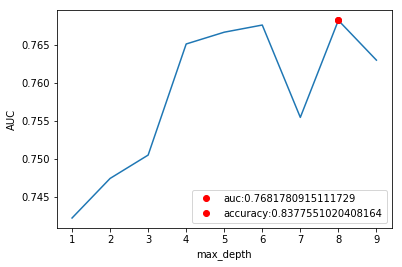

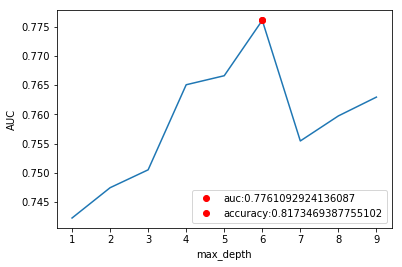

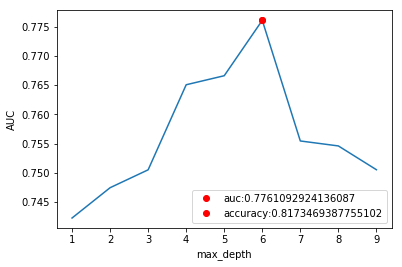

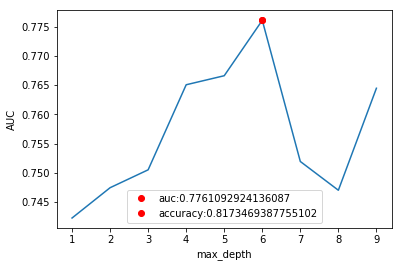

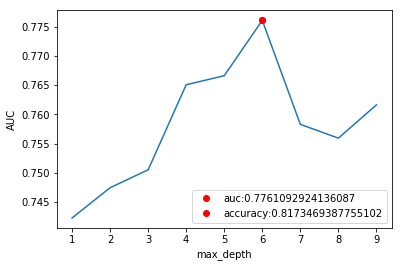

In [386]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []

    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)
        bdt.fit(X_train_sc, y_train)
        a.append(i)
        b.append(metrics.roc_auc_score(y_test, bdt.predict(X_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(X_test_sc, y_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max(b)))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(X_test_sc, y_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

### Red Wine

#### Without upsampling

In [389]:
# select subset of features
rX_chosen = red_df[['volatile acidity', 'alcohol', 'residual sugar']]
X_train, X_test, y_train, y_test = ms.train_test_split(rX_chosen, ry, test_size=0.2)

In [390]:
y_train[y_train < 7] = 0
y_train[y_train > 6] = 1

y_test[y_test < 7] = 0
y_test[y_test > 6] = 1

y_train.value_counts()

0    1093
1     186
Name: quality, dtype: int64

In [392]:
scaler = preproc.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)  # scale X_train
X_test_sc = scaler.transform(X_test)  

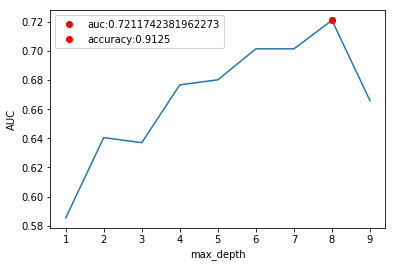

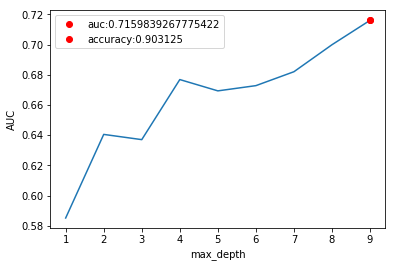

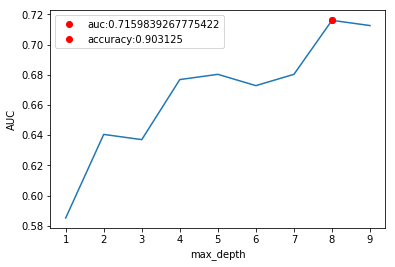

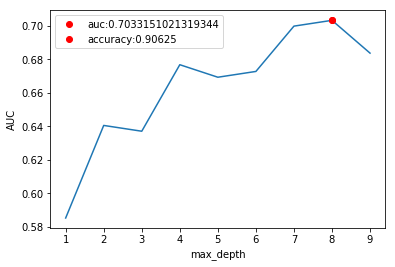

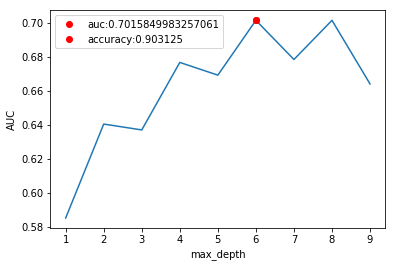

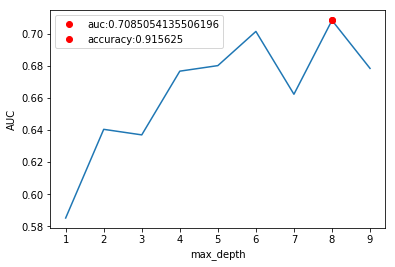

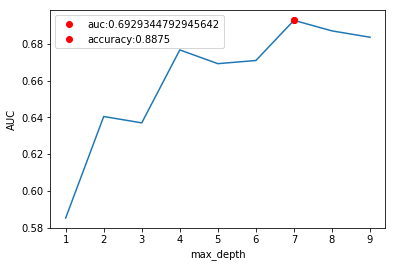

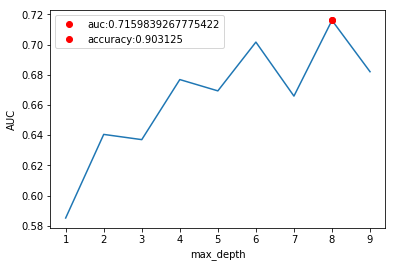

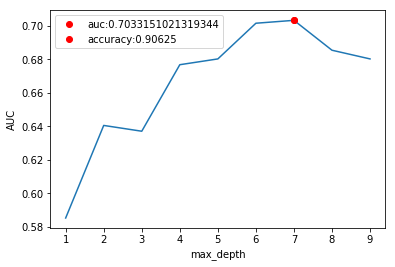

In [393]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)
        bdt.fit(X_train_sc, y_train)
        a.append(i)
        b.append(metrics.roc_auc_score(y_test, bdt.predict(X_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(X_test_sc, y_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(X_test_sc, y_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### With upsampling

In [399]:
rX_chosen = red_df[['volatile acidity', 'alcohol', 'residual sugar']]
X_train, X_test, y_train, y_test = ms.train_test_split(rX_chosen, ry, test_size=0.2)

In [400]:
y_train[y_train < 7] = 0
y_train[y_train > 6] = 1

y_test[y_test < 7] = 0
y_test[y_test > 6] = 1

y_train.value_counts()

0    1097
1     182
Name: quality, dtype: int64

In [401]:
# upsample
X_train, y_train = upsample(X_train, y_train)

total samples 2194


In [402]:
scaler = preproc.StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)  # scale X_train
X_test_sc = scaler.transform(X_test)  

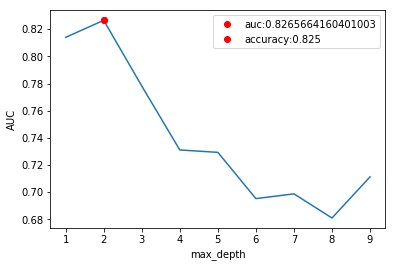

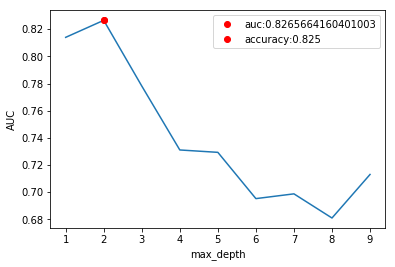

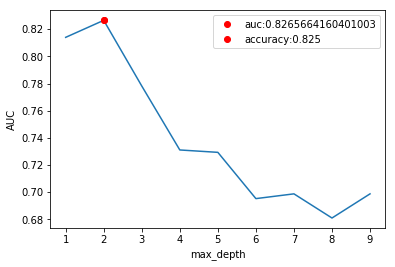

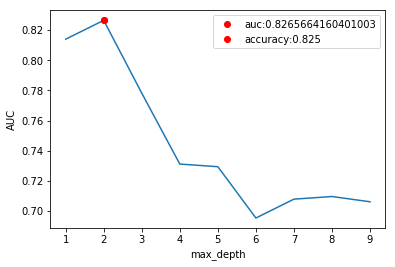

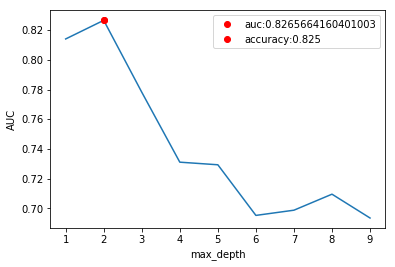

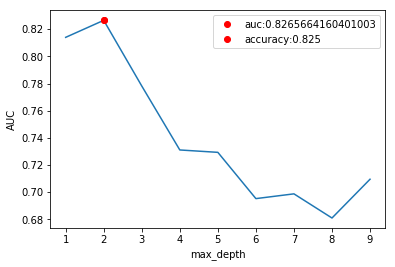

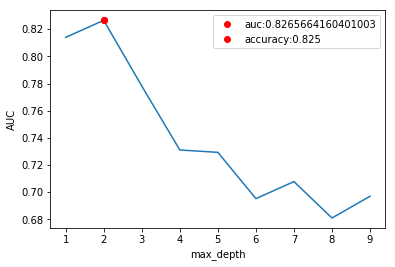

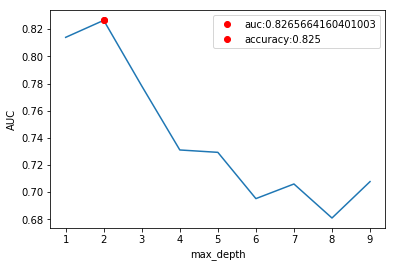

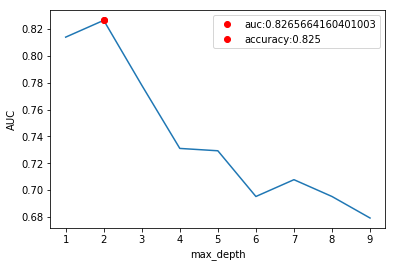

In [404]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc against max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)
        bdt.fit(X_train_sc, y_train)
        a.append(i)
        b.append(metrics.roc_auc_score(y_test, bdt.predict(X_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(X_test_sc, y_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(X_test_sc, y_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

## Adaboost with features selected using PCA

In [141]:
wX = white_df.drop(['quality'], axis=1)
wy = white_df ['quality']

In [142]:
rX = red_df.drop(['quality'], axis=1)
ry = red_df ['quality']

In [143]:
# perform PCA analysis to identify features that contribute to the greatest amount of variance
wpca = PCA(n_components=2).fit(wX)
wX_pca = wpca.transform(wX)

rpca = PCA(n_components=2).fit(rX)
rX_pca = rpca.transform(rX)

print('white')
print(wpca.explained_variance_ratio_) 

# chlorides, total sulfur dioxide, and alcohol have largest coefficients in first component:
print(wpca.components_ )

print('red')
print(rpca.explained_variance_ratio_) 

# residual sugar, total sulfur dioxide, and alcohol have largest coefficients in first component
print(rpca.components_ )

white
[0.90965734 0.07933386]
[[ 1.54440234e-03  1.69003682e-04  3.38650580e-04  4.73275284e-02
   9.75740505e-05  2.61877002e-01  9.63857636e-01  3.59698303e-05
   3.38465456e-06  3.40902808e-04 -1.25037482e-02]
 [-9.16349763e-03 -1.54546977e-03  1.40306911e-04  1.49431815e-02
  -7.18299806e-05  9.64685369e-01 -2.62736857e-01 -1.83631853e-05
  -4.16985633e-05 -3.61111182e-04  6.45519597e-03]]
red
[0.94657698 0.0483683 ]
[[-6.13247431e-03  3.84465551e-04  1.70902595e-04  8.64894648e-03
   6.37307290e-05  2.18857434e-01  9.75678369e-01  3.72498542e-06
  -2.68008619e-04  2.23381730e-04 -6.35846721e-03]
 [-2.38994985e-02 -2.00966661e-03 -3.03480788e-03  1.11348551e-02
  -2.36654751e-04  9.75265982e-01 -2.18916841e-01 -2.49998510e-05
   3.27182194e-03  6.18926046e-04  1.45642451e-02]]


### Consider the 3 features with greatest variance for white and red wine

White wine:
- Chlorides
- Total Sulfur Dioxide
- Alcohol

Red wine:
- Residual Sugar
- Total Sulfur Dioxide
- Alcohol

### Without Upsampling

In [300]:
# select subset of features
wX = white_df[['chlorides', 'total sulfur dioxide','alcohol']]
rX = red_df[['residual sugar', 'total sulfur dioxide','alcohol']]

In [301]:
wX_train, wX_test, wy_train, wy_test = ms.train_test_split(wX, wy, test_size=0.2)
rX_train, rX_test, ry_train, ry_test = ms.train_test_split(rX, ry, test_size=0.2)

In [302]:
wy_train[wy_train < 7] = 0
wy_train[wy_train > 6] = 1

wy_test[wy_test < 7] = 0
wy_test[wy_test > 6] = 1

ry_train[ry_train < 7] = 0
ry_train[ry_train > 6] = 1

ry_test[ry_test < 7] = 0
ry_test[ry_test > 6] = 1

In [304]:
wy_train.value_counts()

0    3075
1     843
Name: quality, dtype: int64

In [305]:
ry_train.value_counts()

0    1098
1     181
Name: quality, dtype: int64

In [306]:
scaler = preproc.StandardScaler()
scaler.fit(wX_train)
wX_train_sc = scaler.transform(wX_train)  # scale X_train
wX_test_sc = scaler.transform(wX_test) 

In [307]:
scaler = preproc.StandardScaler()
scaler.fit(rX_train)
rX_train_sc = scaler.transform(rX_train)  # scale X_train
rX_test_sc = scaler.transform(rX_test) 

total samples 2196


#### White wine (chlorides, total sulfur dioxide, and alcohol)

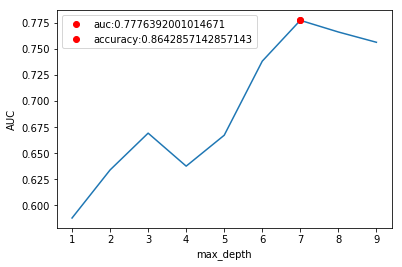

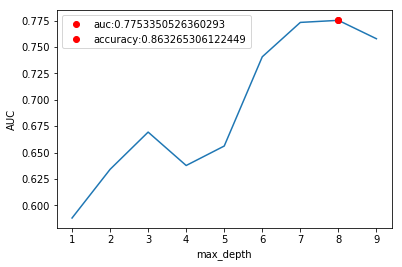

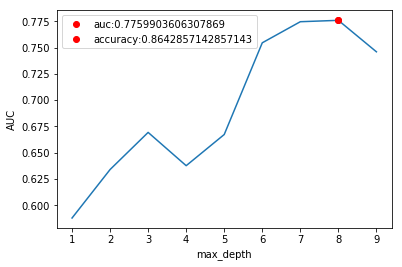

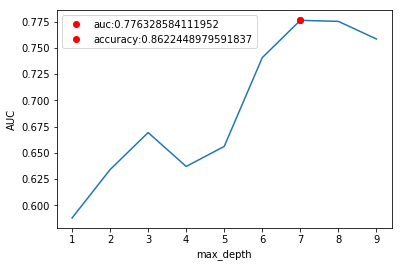

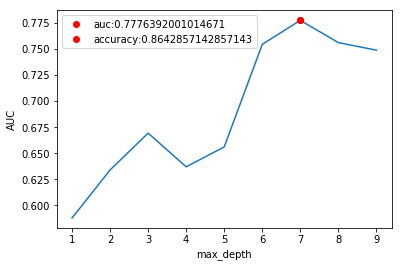

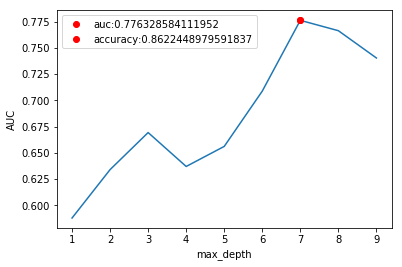

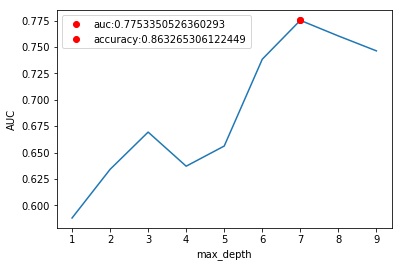

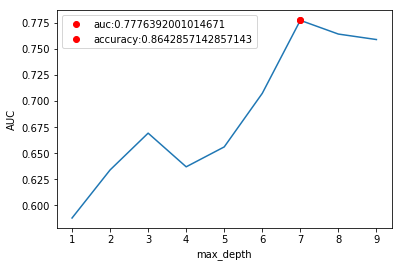

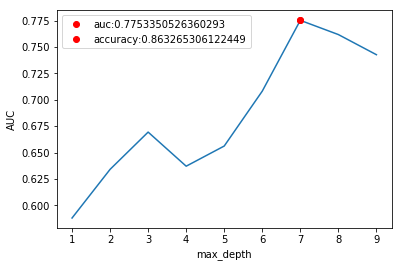

In [407]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc vs max_depth
    for i in range(1,10):

        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(wX_train_sc, wy_train)
        a.append(i)
        b.append(metrics.roc_auc_score(wy_test, bdt.predict(wX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(wX_test_sc, wy_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### Red wine (residual sugar, total sulfur dioxide, and alcohol)

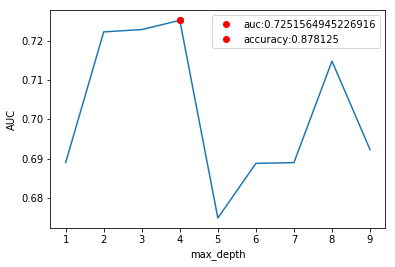

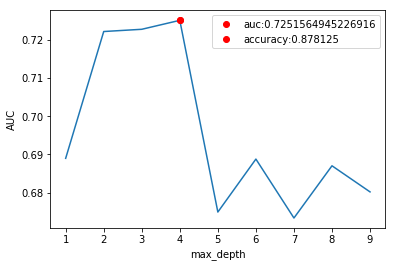

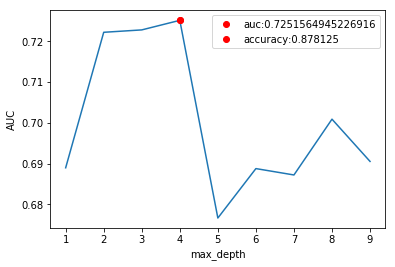

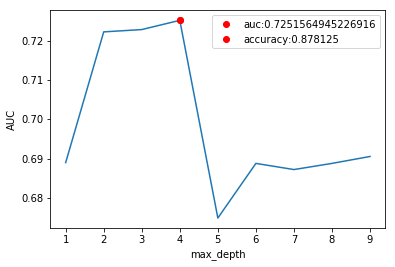

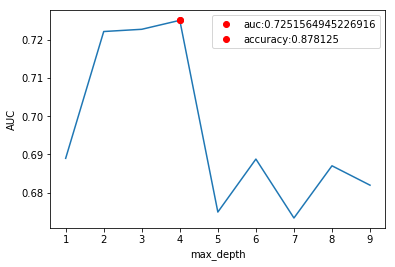

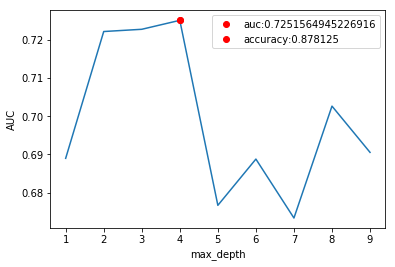

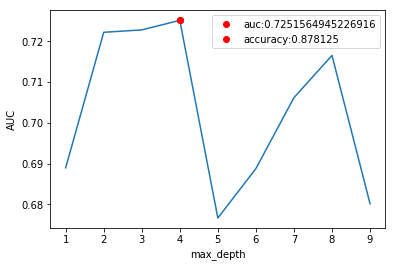

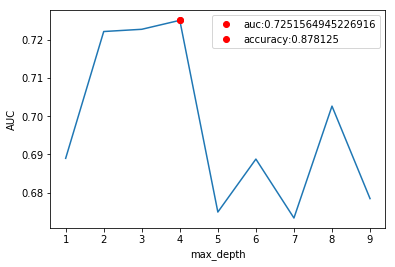

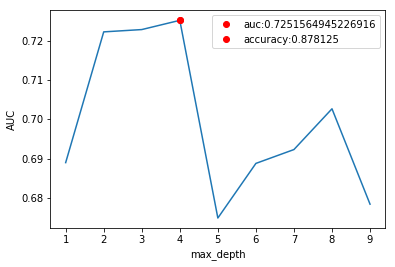

In [408]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc vs max_depth
    for i in range(1,10):

        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(rX_train_sc, ry_train)
        a.append(i)
        b.append(metrics.roc_auc_score(ry_test, bdt.predict(rX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(rX_test_sc, ry_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

### With upsampling

In [409]:
wX = white_df[['chlorides', 'total sulfur dioxide','alcohol']]
rX = red_df[['residual sugar', 'total sulfur dioxide','alcohol']]

In [410]:
wX_train, wX_test, wy_train, wy_test = ms.train_test_split(wX, wy, test_size=0.2)
rX_train, rX_test, ry_train, ry_test = ms.train_test_split(rX, ry, test_size=0.2)

In [411]:
wy_train[wy_train < 7] = 0
wy_train[wy_train > 6] = 1

wy_test[wy_test < 7] = 0
wy_test[wy_test > 6] = 1

ry_train[ry_train < 7] = 0
ry_train[ry_train > 6] = 1

ry_test[ry_test < 7] = 0
ry_test[ry_test > 6] = 1

In [412]:
# upsample
wX_train, wy_train = upsample(wX_train, wy_train)
rX_train, ry_train = upsample(rX_train, ry_train)

total samples 6156
total samples 2212


In [413]:
wy_train.value_counts()

1    3078
0    3078
Name: quality, dtype: int64

In [414]:
ry_train.value_counts()

1    1106
0    1106
Name: quality, dtype: int64

In [415]:
scaler = preproc.StandardScaler()
scaler.fit(wX_train)
wX_train_sc = scaler.transform(wX_train)  # scale X_train
wX_test_sc = scaler.transform(wX_test) 

In [416]:
scaler = preproc.StandardScaler()
scaler.fit(rX_train)
rX_train_sc = scaler.transform(rX_train)  # scale X_train
rX_test_sc = scaler.transform(rX_test) 

total samples 2212


#### White wine (chlorides, total sulfur dioxide, and alcohol)

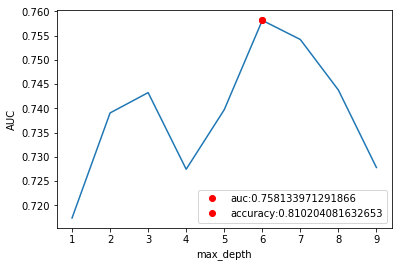

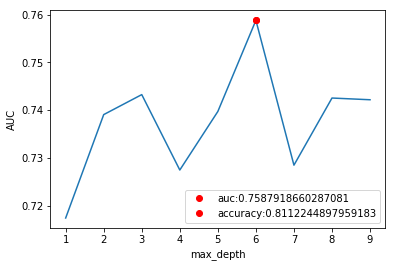

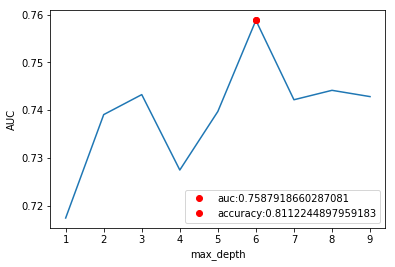

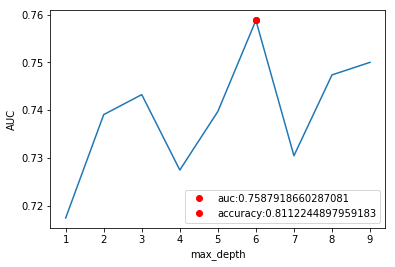

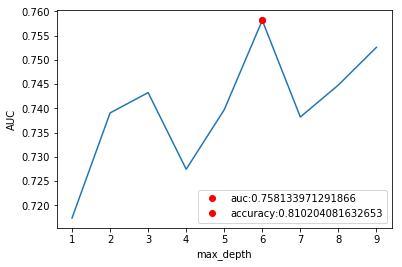

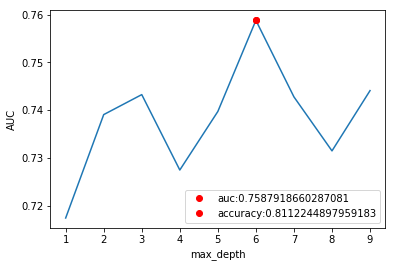

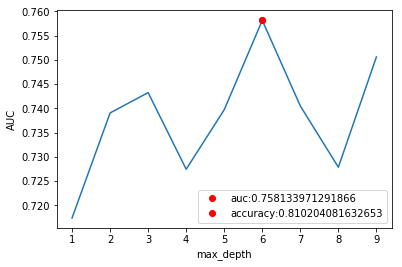

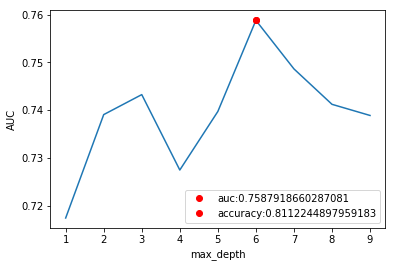

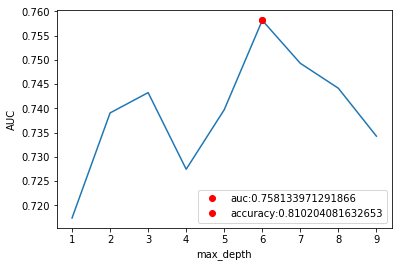

In [417]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc vs max_depth
    for i in range(1,10):

        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(wX_train_sc, wy_train)
        a.append(i)
        b.append(metrics.roc_auc_score(wy_test, bdt.predict(wX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(wX_test_sc, wy_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

#### Red wine (residual sugar, total sulfur dioxide, and alcohol)

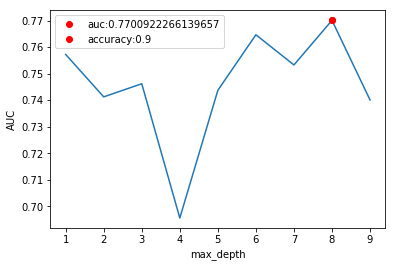

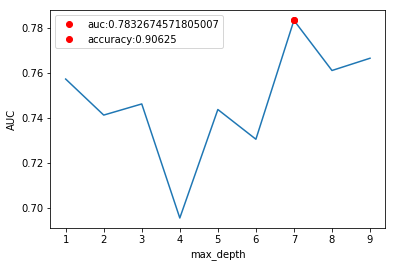

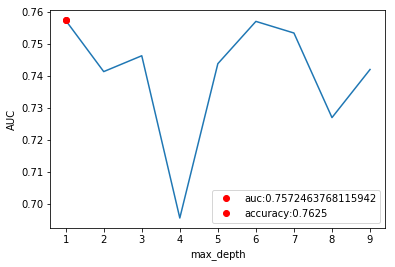

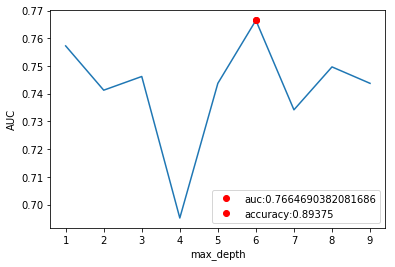

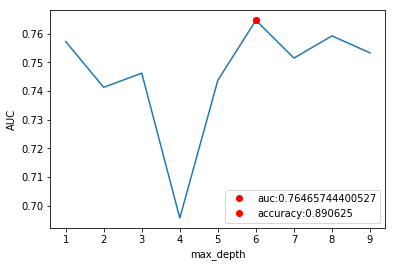

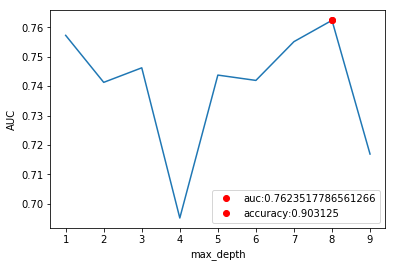

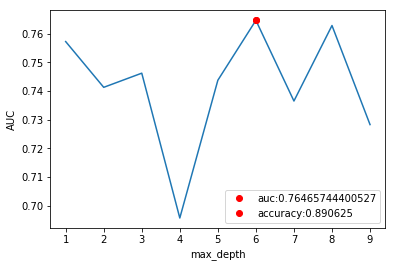

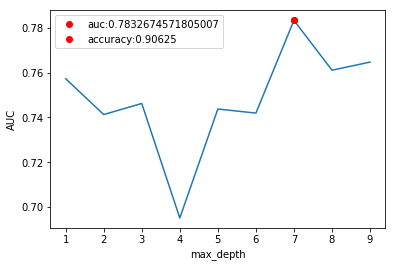

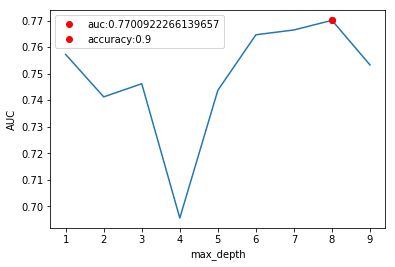

In [418]:
# 10 plots
for n in range(1,10):
    a = []
    b = []
    bdts = []
    
    # plot auc vs max_depth
    for i in range(1,10):
        bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=i),
                                 algorithm="SAMME",
                                 n_estimators=200)

        bdt.fit(rX_train_sc, ry_train)
        a.append(i)
        b.append(metrics.roc_auc_score(ry_test, bdt.predict(rX_test_sc)))
#         print("AdaBoost Accuracy for", "max_depth=",str(i), ":",bdt.score(wX_test_sc, wy_test))
        bdts.append(bdt)

    max_accuracy = max(b)
    plt.plot(a, b)
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
    plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='accuracy:' + str(bdts[np.argmax(b)].score(rX_test_sc, ry_test)))
    plt.xlabel('max_depth')
    plt.ylabel('AUC')
    plt.legend()
    plt.show()

# Appendix

## KNN Analysis With All Variables 

In [262]:
wX = white_df.drop(['quality'], axis=1)
wy = white_df ['quality']

In [263]:
rX = red_df.drop(['quality'], axis=1)
ry = red_df ['quality']

In [264]:
# split into training and validation sets
wX_train, wX_test, wy_train, wy_test = ms.train_test_split(wX, wy, test_size=0.2)
rX_train, rX_test, ry_train, ry_test = ms.train_test_split(rX, ry, test_size=0.2)

In [265]:
# binary classes for white wine
wy_train[wy_train < 7] = 0
wy_train[wy_train > 6] = 1

wy_test[wy_test < 7] = 0
wy_test[wy_test > 6] = 1

# binary classes for red wine
ry_train[ry_train < 7] = 0
ry_train[ry_train > 6] = 1

ry_test[ry_test < 7] = 0
ry_test[ry_test > 6] = 1

In [266]:
wy_train.value_counts(normalize=True)

0    0.780755
1    0.219245
Name: quality, dtype: float64

In [267]:
wy_test.value_counts(normalize=True)

0    0.794898
1    0.205102
Name: quality, dtype: float64

In [268]:
scaler = preproc.StandardScaler()
scaler.fit(wX_train)
wX_train_sc = scaler.transform(wX_train)  # scale X_train
wX_test_sc = scaler.transform(wX_test)

In [269]:
scaler = preproc.StandardScaler()
scaler.fit(rX_train)
rX_train_sc = scaler.transform(rX_train)  # scale X_train
rX_test_sc = scaler.transform(rX_test) 

In [270]:
from sklearn.neighbors import KNeighborsClassifier
print('White Wine')
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(wX_train_sc, wy_train)
print('accuracy:', knn.score(wX_test_sc, wy_test))
print('auc:',metrics.roc_auc_score(wy_test, knn.predict(wX_test_sc)))

White Wine
accuracy: 0.8173469387755102
auc: 0.6802348974000345


In [271]:
from sklearn.neighbors import KNeighborsClassifier
print('Red Wine')
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(rX_train_sc, ry_train)
print('accuracy:', knn.score(rX_test_sc, ry_test))
print('auc:',metrics.roc_auc_score(ry_test, knn.predict(rX_test_sc)))

Red Wine
accuracy: 0.89375
auc: 0.7142857142857143


# Random Forest Analysis With All Variables 

White Wine
Random Forest Classifie Accuracy for max_samples= 1 : 0.6928571428571428
Random Forest Classifie Accuracy for max_samples= 2 : 0.7081632653061225
Random Forest Classifie Accuracy for max_samples= 3 : 0.7377551020408163
Random Forest Classifie Accuracy for max_samples= 4 : 0.746938775510204
Random Forest Classifie Accuracy for max_samples= 5 : 0.7642857142857142
Random Forest Classifie Accuracy for max_samples= 6 : 0.7826530612244897
Random Forest Classifie Accuracy for max_samples= 7 : 0.8010204081632653
Random Forest Classifie Accuracy for max_samples= 8 : 0.823469387755102
Random Forest Classifie Accuracy for max_samples= 9 : 0.8295918367346938
Random Forest Classifie Accuracy for max_samples= 10 : 0.8489795918367347


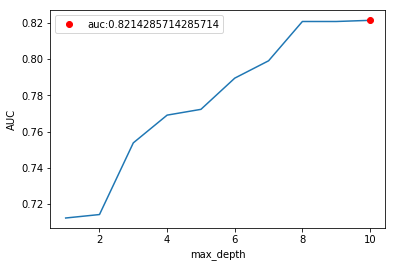

In [450]:
from sklearn.ensemble import RandomForestClassifier
print('White Wine')
a = []
b = []

# plot auc vs max_samples
for i in range(1,11):
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=i, max_features="sqrt", \
                                     random_state=0)

    random_forest.fit(wX_train_sc, wy_train)
    a.append(i)
    b.append(metrics.roc_auc_score(wy_test, random_forest.predict(wX_test_sc)))
    print("Random Forest Classifie Accuracy for", "max_samples=",str(i), ":",random_forest.score(wX_test_sc, wy_test))

    
max_accuracy = max(b) 
plt.plot(a, b) 
plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
plt.xlabel('max_depth') 
plt.ylabel('AUC')
plt.legend()
plt.show() 

Red Wine
Random Forest Classifie Accuracy for max_samples= 1 : 0.875
Random Forest Classifie Accuracy for max_samples= 2 : 0.875
Random Forest Classifie Accuracy for max_samples= 3 : 0.8875
Random Forest Classifie Accuracy for max_samples= 4 : 0.89375
Random Forest Classifie Accuracy for max_samples= 5 : 0.884375
Random Forest Classifie Accuracy for max_samples= 6 : 0.896875
Random Forest Classifie Accuracy for max_samples= 7 : 0.90625
Random Forest Classifie Accuracy for max_samples= 8 : 0.909375
Random Forest Classifie Accuracy for max_samples= 9 : 0.925


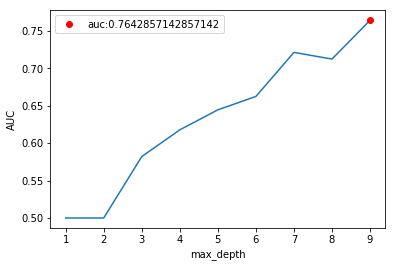

In [275]:
print('Red Wine')
a = []
b = []

# plot auc vs max_samples
for i in range(1,10):

    random_forest = RandomForestClassifier(n_estimators=100, max_depth=i, max_features="sqrt", \
                                     random_state=0)

    random_forest.fit(rX_train_sc, ry_train)
    a.append(i)
    b.append(metrics.roc_auc_score(ry_test, random_forest.predict(rX_test_sc)))
    print("Random Forest Classifie Accuracy for", "max_samples=",str(i), ":",random_forest.score(rX_test_sc, ry_test))

    
max_accuracy = max(b) 
plt.plot(a, b) 
plt.plot(b.index(max(b)) + 1, max(b) , 'ro', label='auc:' + str(max_accuracy))
plt.xlabel('max_depth') 
plt.ylabel('AUC')
plt.legend()
plt.show() 

## Naive Bayes Analysis With All Variables

In [276]:
print('White Wine')
gnb = GaussianNB()
gnb.fit(wX_train_sc, wy_train)
print('accuracy:', gnb.score(wX_test_sc, wy_test))
print('auc:',metrics.roc_auc_score(wy_test, gnb.predict(wX_test_sc)))

White Wine
accuracy: 0.7163265306122449
auc: 0.7089775768142599


In [277]:
print('Red Wine')
gnb = GaussianNB()
gnb.fit(rX_train_sc, ry_train)
print('accuracy:', gnb.score(rX_test_sc, ry_test))
print('auc:',metrics.roc_auc_score(ry_test, gnb.predict(rX_test_sc)))

Red Wine
accuracy: 0.875
auc: 0.8


## Neural Network (Maximizing AUC) With All Variables

### White Wine

In [78]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import tflearn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

dftr = pd.read_csv('train.csv')
dfte = pd.read_csv('test.csv')

dftr = dftr.iloc[:,1:]
dfte = dfte.iloc[:,1:]

X_train = dftr.iloc[:,:-1].to_numpy()
y_train = dftr.iloc[:,-1].to_numpy()

X_test = dfte.iloc[:,:-1].to_numpy()
y_test = dfte.iloc[:,-1].to_numpy()

# one hot encode training data
ones = y_train
zeros = np.array(y_train == 0, dtype='int64')
y_train = pd.DataFrame(np.array([zeros, ones]).T)
y_train = y_train.to_numpy()

# one hot encode validation data
ones = y_test
zeros = np.array(y_test == 0, dtype='int64')
y_test = pd.DataFrame(np.array([zeros, ones]).T)
y_test = y_test.to_numpy()

print(X_train.shape)
print(y_train.shape)

(6152, 11)
(6152, 2)


In [66]:
ypreds = []
valcounts = []
auc = []

# Building deep neural network using tflearn, which supports roc_auc_score loss fn (maximizes AUC)
tf.reset_default_graph()

input_layer = tflearn.input_data(shape=[None, 11])
dense = tflearn.fully_connected(input_layer, 7, activation='relu')
softmax = tflearn.fully_connected(dense, 2, activation='softmax')

sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.96, decay_step=100)
net = tflearn.regression(softmax, optimizer=sgd, loss='roc_auc_score') # using roc_auc_score as loss function

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X_train, y_train, n_epoch=400)

print('predictions')
y_pred = model.predict(X_test)
y_predn = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred)) > 0.5, dtype='int')[:,1]
y_testn = y_test[:,1]

ypreds.append(y_predn)
valcounts.append(pd.DataFrame(y_predn)[0].value_counts())
auc.append(roc_auc_score(y_testn, y_predn))

Training Step: 38799  | total loss: 15.47821 | time: 0.244s
| SGD | epoch: 400 | loss: 15.47821 -- iter: 6144/6152
Training Step: 38800  | total loss: 15.42105 | time: 0.246s
| SGD | epoch: 400 | loss: 15.42105 -- iter: 6152/6152
--
predictions


#### Training AUC and Accuracy

In [83]:
y_pred_train = model.predict(X_train)
y_predn_train = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred_train)) > 0.5, dtype='int')[:,1]
y_trainn = y_train[:,1]
print(roc_auc_score(y_trainn, y_pred_train[:,1])) # auc
print(accuracy_score(y_trainn, y_predn_train)) # accuracy

0.8493418677423773
0.7719440832249674


In [87]:
confusion_matrix(y_train[:,1], y_predn_train)

array([[2226,  850],
       [ 553, 2523]])

#### Test AUC and Accuracy

In [82]:
y_pred = model.predict(X_test)
y_predn = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred)) > 0.5, dtype='int')[:,1]
y_testn = y_test[:,1]
print(roc_auc_score(y_testn, y_pred[:,1])) # auc
print(accuracy_score(y_testn, y_predn)) # accuracy

0.8438741602253848
0.7346938775510204


In [86]:
confusion_matrix(y_test[:,1], y_predn)

array([[549, 213],
       [ 47, 171]])

### Red Wine

In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
import tflearn
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

dftr = pd.read_csv('rtrain.csv')
dfte = pd.read_csv('rtest.csv')

dftr = dftr.iloc[:,1:]
dfte = dfte.iloc[:,1:]

X_train = dftr.iloc[:,:-1].to_numpy()
y_train = dftr.iloc[:,-1].to_numpy()

X_test = dfte.iloc[:,:-1].to_numpy()
y_test = dfte.iloc[:,-1].to_numpy()

# one hot encoding train
ones = y_train
zeros = np.array(y_train == 0, dtype='int64')
y_train = pd.DataFrame(np.array([zeros, ones]).T)
y_train = y_train.to_numpy()

# one hot encoding test
ones = y_test
zeros = np.array(y_test == 0, dtype='int64')
y_test = pd.DataFrame(np.array([zeros, ones]).T)
y_test = y_test.to_numpy()

print(X_train.shape)
print(y_train.shape)

Instructions for updating:
Colocations handled automatically by placer.
(2214, 11)
(2214, 2)


In [2]:
ypreds = []
valcounts = []
auc = []

# Building deep neural network using tflearn, which supports roc_auc_score loss fn (maximizes AUC)
tf.reset_default_graph()

input_layer = tflearn.input_data(shape=[None, 11])
dense = tflearn.fully_connected(input_layer, 7, activation='relu')
softmax = tflearn.fully_connected(dense, 2, activation='softmax')

sgd = tflearn.SGD(learning_rate=0.1, lr_decay=0.96, decay_step=100)
net = tflearn.regression(softmax, optimizer=sgd, loss='roc_auc_score') # roc_auc_score loss

# Training
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(X_train, y_train, n_epoch=400)

print('predictions')
y_pred = model.predict(X_test)
y_predn = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred)) > 0.5, dtype='int')[:,1]
y_testn = y_test[:,1]

ypreds.append(y_predn)
valcounts.append(pd.DataFrame(y_predn)[0].value_counts())
auc.append(roc_auc_score(y_testn, y_predn))

Training Step: 13999  | total loss: 7.35872 | time: 0.099s
| SGD | epoch: 400 | loss: 7.35872 -- iter: 2176/2214
Training Step: 14000  | total loss: 6.92756 | time: 0.102s
| SGD | epoch: 400 | loss: 6.92756 -- iter: 2214/2214
--
predictions


#### Training AUC and Accuracy

In [6]:
y_pred_train = model.predict(X_train)
y_predn_train = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred_train)) > 0.5, dtype='int')[:,1]
y_trainn = y_train[:,1]
print(roc_auc_score(y_trainn, y_pred_train[:,1])) # auc
print(accuracy_score(y_trainn, y_predn_train)) # accuracy


0.9455420013399171
0.9056007226738934


In [7]:
confusion_matrix(y_train[:,1], y_predn_train)

array([[ 925,  182],
       [  27, 1080]])

#### Test AUC and Accuracy

In [3]:
y_pred = model.predict(X_test)
y_predn = np.array(tf.Session().run(tf.map_fn(tflearn.activations.softmax, y_pred)) > 0.5, dtype='int')[:,1]
y_testn = y_test[:,1]
print(roc_auc_score(y_testn, y_pred[:,1])) # auc
print(accuracy_score(y_testn, y_predn)) # accuracy

0.847838383838384
0.76875


In [5]:
confusion_matrix(y_test[:,1], y_predn)

array([[212,  63],
       [ 11,  34]])

## Neural Network (5 Class Score Classification) With All Variables

The quality rating score which is on a scale of 0-10 will be compartementalized into 5 classes according to the following criteria.  

Class 0 score = 4 or less   
Class 1 score = 5  
Class 2 score = 6  
Class 3 score = 7  
Class 4 score = 8 or greater  

In [50]:
import pandas as pd
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import *
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras import backend
from keras.utils.np_utils import to_categorical
import tensorflow as tf

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import preprocessing as preproc
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [51]:
#rounds scores 8 or higher down to 8 ( about 5 cases) 
#rounds scores 3 up to 4 ( about 30 cases)
#then centers scores from 1-5
def compartamentalize(data):
    data[data <5] = 4
    data[data >7] = 8
    
    return data - 4

#combines two datasets column wise  (recombines x and y train for upsampling)
def combine_data(x_train, y_train):
    train_df =  pd.concat([x_train, y_train], axis=1, join_axes=[x_train.index])
    return(train_df)

In [52]:
#read in csv
white_df = pd.read_csv('winequality-white.csv', sep =';')
red_df = pd.read_csv('winequality-red.csv', sep =';')

#seperate out quality
white_score = white_df['quality']
red_score = red_df['quality']

In [53]:
#feature engineering
#citric acid is accounted for in fixed acidity, so subtracting out to get less related variables
#splitting total sulfar into free and bonded

real_fixed_acidity = white_df['fixed acidity'] - white_df['citric acid']
bounded_sulfur_dioxide = white_df['free sulfur dioxide'] - white_df['total sulfur dioxide']
white_df = white_df.drop(['fixed acidity','total sulfur dioxide'], axis=1)
white_df['fixed_acidity'] = real_fixed_acidity
white_df['bounded_sulfur_dioxide'] = bounded_sulfur_dioxide


real_fixed_acidity = red_df['fixed acidity'] - red_df['citric acid']
bounded_sulfur_dioxide = red_df['free sulfur dioxide'] - red_df['total sulfur dioxide']
red_df = red_df.drop(['fixed acidity','total sulfur dioxide'], axis=1)
red_df['fixed_acidity'] = real_fixed_acidity
red_df['bounded_sulfur_dioxide'] = bounded_sulfur_dioxide

In [54]:
# changes the quality to a range 0-4
white_y = compartamentalize(white_score) 
white_df = white_df.drop(['quality'], axis=1)
white_df['quality'] = white_y

#changes the quality to a range 0-4
red_y = compartamentalize(red_score) 
red_df = red_df.drop(['quality'], axis=1)
red_df['quality'] = red_y

In [55]:
# creating train and test splits for red and white wine datasets

Xw = white_df.drop(['quality'], axis=1)
yw = white_df['quality']
yw = label_binarize(yw, classes=[0, 1, 2,3,4])
Xw_train, Xw_test, yw_train, yw_test = train_test_split(Xw, yw, test_size=.3,
                                                    random_state=0)

Xr = red_df.drop(['quality'], axis=1)
yr = red_df['quality']
yr = label_binarize(yr, classes=[0, 1, 2, 3, 4])

Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size=.3,
                                                    random_state=0)

In [56]:
#scaling the data
scaler_red = preproc.StandardScaler()
scaler_red.fit(Xr_train)
Xr_train = scaler_red.transform(Xr_train)
Xr_test = scaler_red.transform(Xr_test)

scaler_white = preproc.StandardScaler()
scaler_white.fit(Xw_train)
Xw_train = scaler_white.transform(Xw_train)
Xw_test = scaler_white.transform(Xw_test)

### White Wine

In [40]:
#create model
modelw = Sequential()
modelw.add(Dense(200, input_dim=11, activation='relu',kernel_initializer='random_normal'))
modelw.add(Dropout(0.2))
modelw.add(Dense(100, activation='relu',kernel_initializer='random_normal'))
modelw.add(Dropout(0.2))
modelw.add(Dense(5,activation=tf.nn.softmax))

#Compile model
modelw.compile(loss="categorical_crossentropy", optimizer="adam",metrics =['accuracy'])

In [41]:
#train the model
batch_size = 124
epochs = 200

print('Training the model')
modelw.fit(
    Xw_train,
    yw_train,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

Training the model
Epoch 1/200
3428/3428 [==============================] - 0s 114us/step - loss: 1.4339 - acc: 0.4142
Epoch 2/200
3428/3428 [==============================] - 0s 20us/step - loss: 1.2022 - acc: 0.5280
Epoch 3/200
3428/3428 [==============================] - 0s 20us/step - loss: 1.1325 - acc: 0.5473
Epoch 4/200
3428/3428 [==============================] - 0s 19us/step - loss: 1.0984 - acc: 0.5493
Epoch 5/200
3428/3428 [==============================] - 0s 18us/step - loss: 1.0734 - acc: 0.5546
Epoch 6/200
3428/3428 [==============================] - 0s 17us/step - loss: 1.0577 - acc: 0.5575
Epoch 7/200
3428/3428 [==============================] - 0s 21us/step - loss: 1.0422 - acc: 0.5653
Epoch 8/200
3428/3428 [==============================] - 0s 18us/step - loss: 1.0337 - acc: 0.5616
Epoch 9/200
3428/3428 [==============================] - 0s 17us/step - loss: 1.0252 - acc: 0.5645
Epoch 10/200
3428/3428 [==============================] - 0s 18us/step - loss: 1.0244 - a

3428/3428 [==============================] - 0s 18us/step - loss: 0.8892 - acc: 0.6132
Epoch 164/200
3428/3428 [==============================] - 0s 17us/step - loss: 0.8956 - acc: 0.6149
Epoch 165/200
3428/3428 [==============================] - 0s 16us/step - loss: 0.8800 - acc: 0.6275
Epoch 166/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8939 - acc: 0.6053
Epoch 167/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8837 - acc: 0.6170
Epoch 168/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8887 - acc: 0.6109
Epoch 169/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8989 - acc: 0.6082
Epoch 170/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8901 - acc: 0.6135
Epoch 171/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8780 - acc: 0.6219
Epoch 172/200
3428/3428 [==============================] - 0s 15us/step - loss: 0.8870 - acc: 0.6071
Epoc

#### Plotting Multiclass ROC

In [42]:
n_classes = 5
random_state = np.random.RandomState(0)
y_scorew = modelw.predict(Xw_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yw_test[:, i], y_scorew[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yw_test.ravel(), y_scorew.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

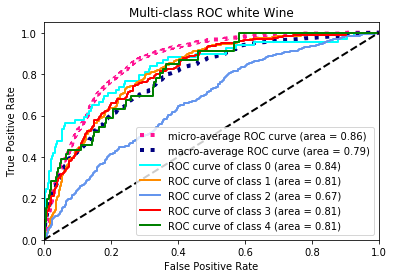

In [44]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC white Wine')
plt.legend(loc="lower right")
plt.show()

### Red Wine

In [32]:
#create model
modelr = Sequential()
modelr.add(Dense(200, input_dim=11, activation='relu',kernel_initializer='random_normal'))
modelr.add(Dropout(0.2))
modelr.add(Dense(100, activation='relu',kernel_initializer='random_normal'))
modelr.add(Dropout(0.2))
modelr.add(Dense(5,activation=tf.nn.softmax))

#Compile model
modelr.compile(loss="categorical_crossentropy", optimizer="adam",metrics =['accuracy'])

In [33]:
#training the model
batch_size = 124
epochs = 200

print('Training the model')
modelr.fit(
    Xr_train,
    yr_train,
    epochs=epochs,
    shuffle=True,
    batch_size=batch_size)

Training the model
Epoch 1/200
1119/1119 [==============================] - 0s 298us/step - loss: 1.5226 - acc: 0.3887
Epoch 2/200
1119/1119 [==============================] - 0s 39us/step - loss: 1.2690 - acc: 0.5424
Epoch 3/200
1119/1119 [==============================] - 0s 39us/step - loss: 1.1097 - acc: 0.5585
Epoch 4/200
1119/1119 [==============================] - 0s 29us/step - loss: 1.0427 - acc: 0.5630
Epoch 5/200
1119/1119 [==============================] - 0s 29us/step - loss: 1.0028 - acc: 0.5737
Epoch 6/200
1119/1119 [==============================] - 0s 34us/step - loss: 0.9922 - acc: 0.5791
Epoch 7/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.9824 - acc: 0.5639
Epoch 8/200
1119/1119 [==============================] - 0s 32us/step - loss: 0.9687 - acc: 0.5621
Epoch 9/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.9554 - acc: 0.5800
Epoch 10/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.9381 - a

1119/1119 [==============================] - 0s 34us/step - loss: 0.6976 - acc: 0.6854
Epoch 164/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.7081 - acc: 0.6962
Epoch 165/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.7154 - acc: 0.6953
Epoch 166/200
1119/1119 [==============================] - 0s 28us/step - loss: 0.7056 - acc: 0.7069
Epoch 167/200
1119/1119 [==============================] - 0s 28us/step - loss: 0.7167 - acc: 0.6890
Epoch 168/200
1119/1119 [==============================] - 0s 29us/step - loss: 0.7053 - acc: 0.6997
Epoch 169/200
1119/1119 [==============================] - 0s 32us/step - loss: 0.7195 - acc: 0.6926
Epoch 170/200
1119/1119 [==============================] - 0s 32us/step - loss: 0.7047 - acc: 0.7060
Epoch 171/200
1119/1119 [==============================] - 0s 32us/step - loss: 0.6992 - acc: 0.7131
Epoch 172/200
1119/1119 [==============================] - 0s 32us/step - loss: 0.6784 - acc: 0.7131
Epoc

#### Plotting Multiclass ROC

In [34]:
n_classes = 5
random_state = np.random.RandomState(0)
y_scorer = modelr.predict(Xr_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yr_test[:, i], y_scorer[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yr_test.ravel(), y_scorer.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

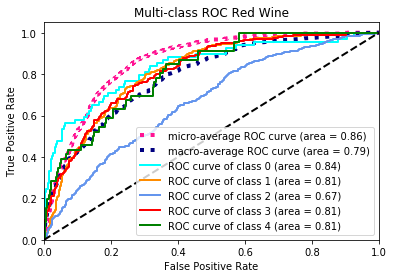

In [45]:
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Red Wine')
plt.legend(loc="lower right")
plt.show()


## Adaboost Grid Search for AUC

In [235]:
DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto",criterion = 'gini', splitter = 'best', max_depth=7)
ABC = AdaBoostClassifier(base_estimator = DTC)

In [238]:
from sklearn.model_selection import GridSearchCV

# tuning adaboost for various parameters
print('Tuning')
param_test1 = {"n_estimators": [700,800],
               'base_estimator__min_samples_split': [2,3]}
gsearch1 = GridSearchCV(estimator = ABC,
                        param_grid = param_test1, 
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False, 
                        cv=4)
gsearch1.fit(wX_train_sc, wy_train)

print('Best params:')
gsearch1.best_params_, gsearch1.best_score_

Tuning
Best params:


({'base_estimator__min_samples_split': 2, 'n_estimators': 700},
 0.9024334353998792)

In [239]:
ABC.fit(wX_train_sc, wy_train)
metrics.roc_auc_score(wy_test, ABC.predict(wX_test_sc))

0.7405912327196355

In [186]:
ABC.get_params().keys()

dict_keys(['algorithm', 'base_estimator__class_weight', 'base_estimator__criterion', 'base_estimator__max_depth', 'base_estimator__max_features', 'base_estimator__max_leaf_nodes', 'base_estimator__min_impurity_decrease', 'base_estimator__min_impurity_split', 'base_estimator__min_samples_leaf', 'base_estimator__min_samples_split', 'base_estimator__min_weight_fraction_leaf', 'base_estimator__presort', 'base_estimator__random_state', 'base_estimator__splitter', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV

# tuning adaboost for various parameters
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [1, 2]}

DTC = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = "auto", max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc')